In [1]:
import brickschema
from brickschema.namespaces import BRICK, RDFS, OWL, TAG, RDF, SH
from rdflib import URIRef
from utils import *
from relationship_relaxation import *
from type_relaxation_rdf import *
import networkx
brick_graph = brickschema.Graph(load_brick=True)

In [2]:
# brick_graph = brickschema.Graph(load_brick=True)

query = """SELECT ?afs ?afsp ?vav WHERE  {
    ?afs    a       brick:Air_Flow_Sensor .
    ?afsp   a       brick:Air_Flow_Setpoint .
    ?afs    brick:isPointOf ?vav .
    ?afsp   brick:isPointOf ?vav .
    ?vav    a   brick:VAV
}"""

query = """SELECT ?afs ?afsp ?vav WHERE  {
    ?afsp   a       brick:Air_Flow_Sensor .
    ?afsp   a       brick:Water_Flow_Sensor
}"""

extract_triples(query)

[['?afsp', 'a', 'brick:Air_Flow_Sensor'],
 ['?afsp', 'a', 'brick:Water_Flow_Sensor']]

In [3]:
get_all_brick_relationships()

[rdflib.term.URIRef('https://brickschema.org/schema/Brick#hasPart'),
 rdflib.term.URIRef('https://brickschema.org/schema/Brick#isFedBy'),
 rdflib.term.URIRef('https://brickschema.org/schema/Brick#isPointOf'),
 rdflib.term.URIRef('https://brickschema.org/schema/Brick#isLocationOf'),
 rdflib.term.URIRef('https://brickschema.org/schema/Brick#hasPoint'),
 rdflib.term.URIRef('https://brickschema.org/schema/Brick#hasLocation'),
 rdflib.term.URIRef('https://brickschema.org/schema/Brick#feeds'),
 rdflib.term.URIRef('https://brickschema.org/schema/Brick#isPartOf')]

In [4]:
def create_ordered_list(triples_copy):
    ordered_list = []
    for item in triples_copy:
        for item_i in item:
            item_new = item_i.split('#')[-1]
            ordered_list.append(item_new)
    ordered_list.sort()
    return ordered_list
                
def relax_triples(G, triples, rules, rule_names, level_itr, node_idx, k_node):
    
    for r_index in range(len(rules)):
        rule = rules[r_index]
    
        for i in range(len(triples)):
            triple = triples[i]
            relaxed_triples = rule(triple)
        
            if len(relaxed_triples) > 0:
                for relaxed_triple in relaxed_triples:
                    triples_copy = triples.copy()
                    triples_copy[i] = relaxed_triple
                    
                    #Checking to see if it exists within graph
                    ordered_list = create_ordered_list(triples_copy)
                    
                    if any(G.nodes.data()[node]['ordered_id'] == ordered_list for node in G) == False:
                        G.add_node(node_idx, query=triples_copy, ordered_id = ordered_list)
                        G.add_edge(k_node, node_idx, rule=rule_names[r_index], level=level_itr, triple=i)
                        node_idx+=1
                        #print('node pass')
                    else:
                        #print('node deleted')
                        pass
                        
    return G, node_idx

def relaxtion_graph(query, limit):
    rules = [ApplyRule_LowerClass, ApplyRule_SiblingClass, ApplyRule_UpperClass, apply_rule_variable_relationship, apply_rule_transitive_relationship]
    rule_names = ['lower', 'sibling', 'upper', 'relationship', 'transitive_relationship']

    triples = extract_triples(query)

    G = networkx.Graph()
    node_idx = 1
    ordered_list = create_ordered_list(triples)
    G.add_node(node_idx, query=triples, ordered_id = ordered_list)
    node_idx+=1
    G_old = G.copy()
        
    # Create First Layer
    start_node = node_idx
    level_itr = 1
    G_new, node_idx = relax_triples(G, triples, rules, rule_names, level_itr, node_idx, k_node=1)
    end_node = node_idx
    G_new = G.copy()

    while len(G_old) < len(G_new):
        level_itr += 1
        print(level_itr)
        for k_node in range(start_node, end_node+1):
            query = G.nodes.data()[k_node]['query']
            triples = query.copy()
            G_old = G_new.copy()
            G_new, node_idx = relax_triples(G, triples, rules, rule_names, level_itr, node_idx, k_node)
        start_node = end_node+1
        end_node = node_idx
        if level_itr > limit:
            break

    return G_new

In [5]:
# TODO: add optimization: check previous triples

In [7]:
query = """SELECT ?afs WHERE  {
    ?afsp   a       brick:Air_Flow_Sensor 
}"""

query = """SELECT ?afs ?afsp ?vav WHERE  {
    ?afs   a       brick:Air_Flow_Sensor .
    ?afsp   a       brick:Water_Flow_Sensor
}"""

G_relaxed = relaxtion_graph(query, limit =10)

2
3


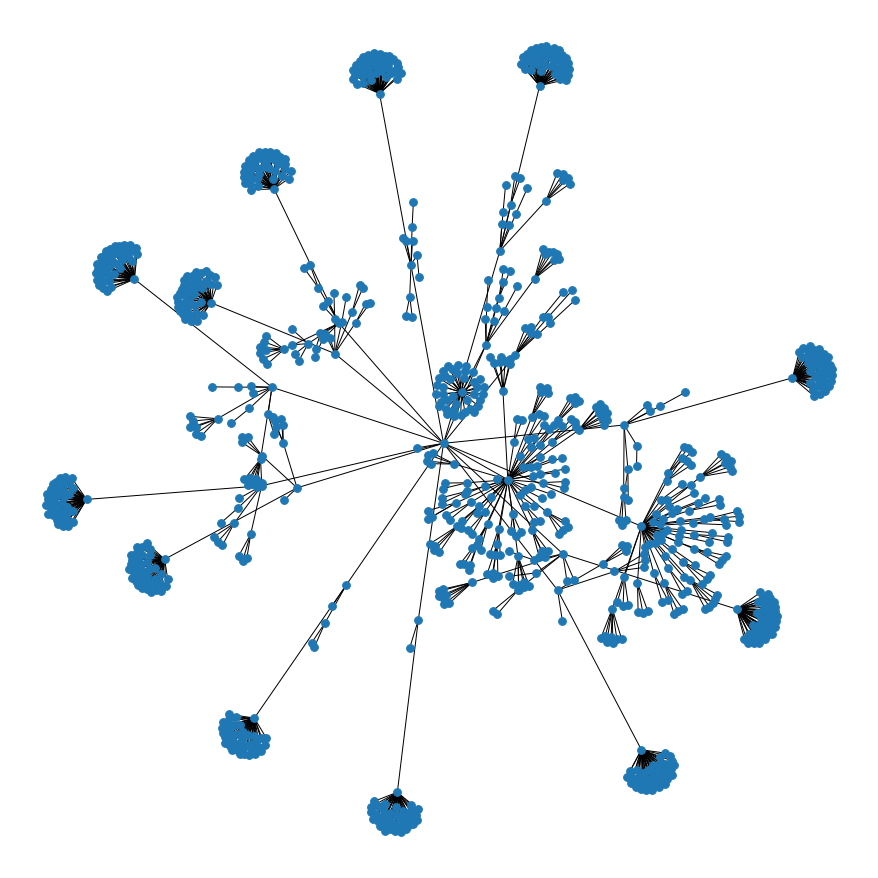

In [10]:
# Not ideal visual just validation
import matplotlib.pyplot as plt
import networkx as nx


# smaller nodes and fonts
plt.figure(3,figsize=(12,12))
nx.draw(G_relaxed,node_size=60,font_size=8) 
plt.show()